# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep =';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep =';')

In [ ]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Display the first five records/rows in the AZDIAS dataset for general demographics
azdias.head()

In [4]:
# Display the last five records/rows in the AZDIAS dataset for general demographics
azdias.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


In [5]:
# Check the dimensions of the AZDIAS dataset for general demographics
print(azdias.shape)
print('Number of rows in the AZDIAS dataset:', azdias.shape[0]) 
print('Number of columns in the AZDIAS dataset:', azdias.shape[1])

(891221, 85)
Number of rows in the AZDIAS dataset: 891221
Number of columns in the AZDIAS dataset: 85


In [6]:
# Display the first five records/rows in the feat_info file(summary of feature attributes for AZDIAS demographics data)
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
# Display the last five records/rows in the feat_info file(summary of feature attributes for AZDIAS demographics data)
feat_info.tail()

,attribute,information_level,type,missing_or_unknown
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"
84,RELAT_AB,community,ordinal,"[-1,9]"


In [8]:
# Check the dimensions of the feat_info file(summary of feature attributes for AZDIAS demographics data) 
print(feat_info.shape)
print('Number of rows in the Feature Summary:', feat_info.shape[0])
print('Number of columns in the Feature Summary:', feat_info.shape[1])

(85, 4)
Number of rows in the Feature Summary: 85
Number of columns in the Feature Summary: 4


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.

# Total number of missing values in the entire AZDIAS dataset before converting the missing values into NANs
azdias.isnull().sum().sum()

4896838

In [10]:
# Check the values of the 'missing_or_unknown' column before parsing
for record in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[record]['missing_or_unknown']
    print(missing_or_unknown)

[-1,0]
[-1,0,9]
[-1,0]
[0]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[0]
[]
[]
[-1,0]
[0]
[0]
[0]
[0]
[0]
[0]
[-1,0]
[-1,0]
[0]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1]
[-1]
[-1,0]
[-1]
[-1,9]
[0]
[]
[]
[-1,0]
[-1]
[-1,0]
[-1,0]
[0]
[]
[-1,0]
[]
[0]
[-1]
[-1]
[-1,X]
[XX]
[-1,XX]
[-1]
[-1]
[-1]
[-1]
[-1,0]
[-1,0]
[-1]
[-1]
[-1]
[]
[-1,0]
[]
[]
[-1,0]
[]
[-1]
[-1]
[-1]
[-1]
[-1,0]
[-1]
[-1]
[-1,9]
[-1,0]
[-1,9]


In [11]:
# Check the values of the 'missing_or_unknown' column after parsing
for record in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[record]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    print (missing_or_unknown)

['-1', '0']
['-1', '0', '9']
['-1', '0']
['0']
['-1']
['-1']
['-1']
['-1']
['-1']
['-1']
['-1']
['0']
['']
['']
['-1', '0']
['0']
['0']
['0']
['0']
['0']
['0']
['-1', '0']
['-1', '0']
['0']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1', '9']
['-1']
['-1']
['-1', '0']
['-1']
['-1', '9']
['0']
['']
['']
['-1', '0']
['-1']
['-1', '0']
['-1', '0']
['0']
['']
['-1', '0']
['']
['0']
['-1']
['-1']
['-1', 'X']
['XX']
['-1', 'XX']
['-1']
['-1']
['-1']
['-1']
['-1', '0']
['-1', '0']
['-1']
['-1']
['-1']
['']
['-1', '0']
['']
['']
['-1', '0']
['']
['-1']
['-1']
['-1']
['-1']
['-1', '0']
['-1']
['-1']
['-1', '9']
['-1', '0']
['-1', '9']


In [4]:
# Convert the missing values in the AZDIAS dataset into NANs
for record in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[record]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[record]['attribute']: missing_or_unknown}, np.nan)

In [13]:
# Check the total number of missing values in the entire AZDIAS dataset after converting the missing values into NANs
azdias.isnull().sum().sum()

8373929

In [14]:
# Check AZDIAS dataset values after converting missing values into NANs 
# Display the first five records/rows
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [15]:
# Check AZDIAS dataset values after converting missing values into NANs 
# Display the last five records/rows
azdias.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,NaN,3.0,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,NaN,2.0,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,NaN,2.0,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,NaN,1.0,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,NaN,4.0,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [5]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Explore the total number of missing values in each column of the AZDIAS dataset 
null_column_azdias = azdias.isnull().sum()
null_column_azdias

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [6]:
# Display the total number of missing values in each column of the AZDIAS dataset as a percentage

#percent_null_column_azdias = null_column_azdias/len(azdias)
 
percent_null_column_azdias = null_column_azdias/len(azdias)*100
percent_null_column_azdias

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

In [7]:
# Display the total number of missing values in each column of the AZDIAS data set as an ordered percentage
# Columns with the highest percentage of missing values appear first
 
#sorted_percent_null_column_azdias = null_column_azdias.sort_values(ascending = False)/len(azdias)

sorted_percent_null_column_azdias = null_column_azdias.sort_values(ascending = False)/len(azdias)*100
sorted_percent_null_column_azdias

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

In [19]:
# Investigate patterns in the amount of missing data in each column.
null_column_azdias.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

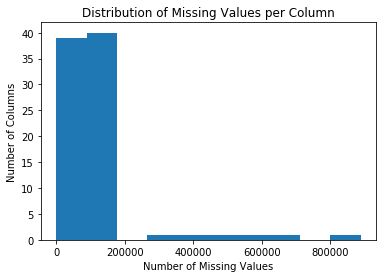

In [20]:
# Visualization of the total number of missing data in each column of the AZDIAS dataset

#null_column_azdias.hist(grid=False) 

plt.hist(null_column_azdias)
plt.title('Distribution of Missing Values per Column')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Columns')
plt.show() 

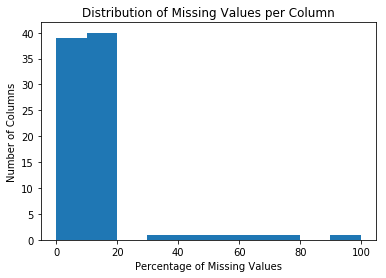

In [21]:
# Visualization of the percentage of missing data in each column of the AZDIAS dataset
 
#percent_null_column_azdias.hist(grid=False)

plt.hist(percent_null_column_azdias)
plt.title('Distribution of Missing Values per Column')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Columns')
plt.show() 

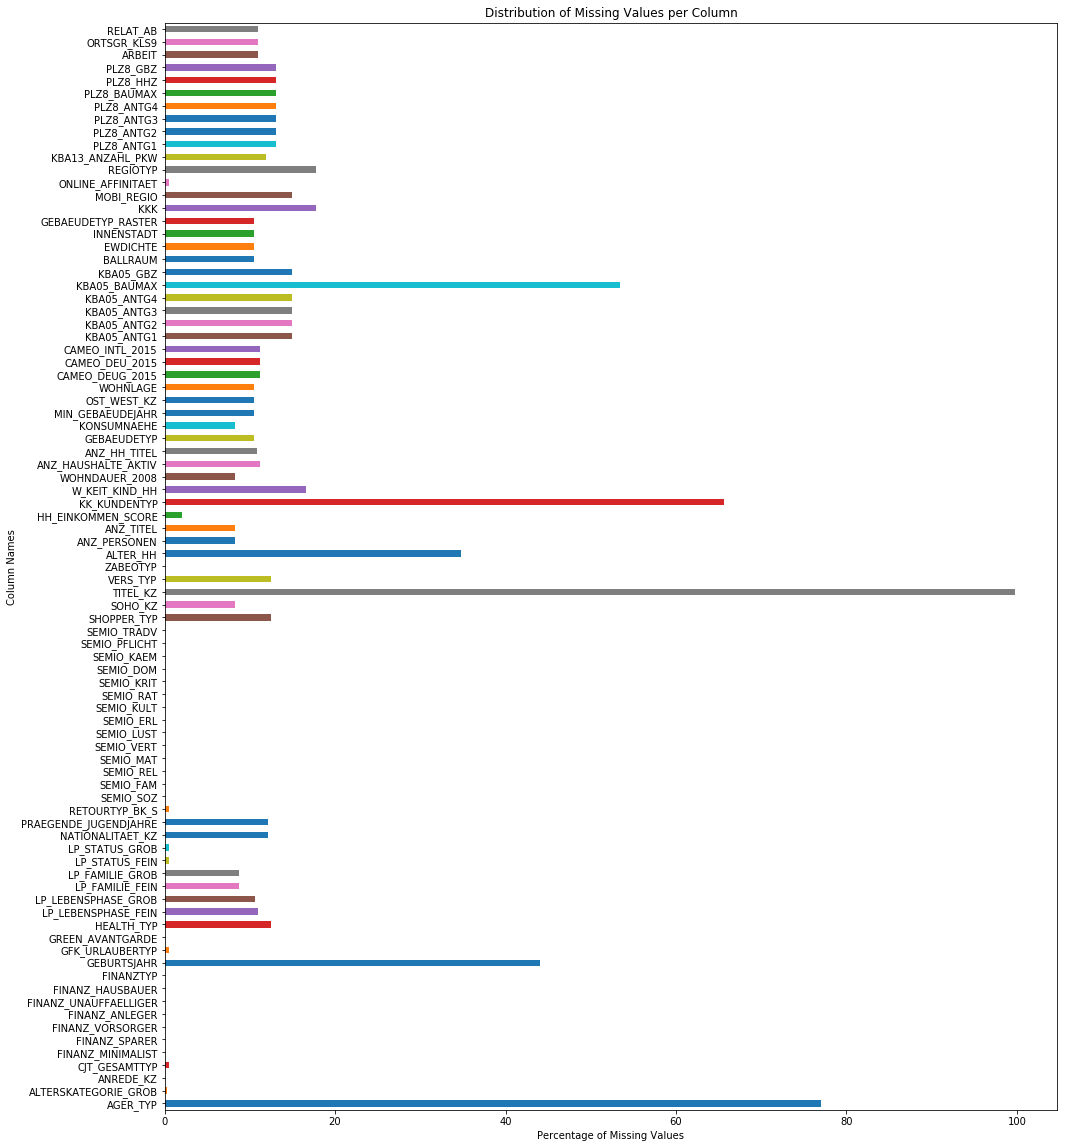

In [22]:
# Another visualization of the percentage of missing data in each column of the AZDIAS dataset
percent_null_column_azdias.plot.barh(figsize=(16,20))
plt.title('Distribution of Missing Values per Column')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Column Names')
plt.show()

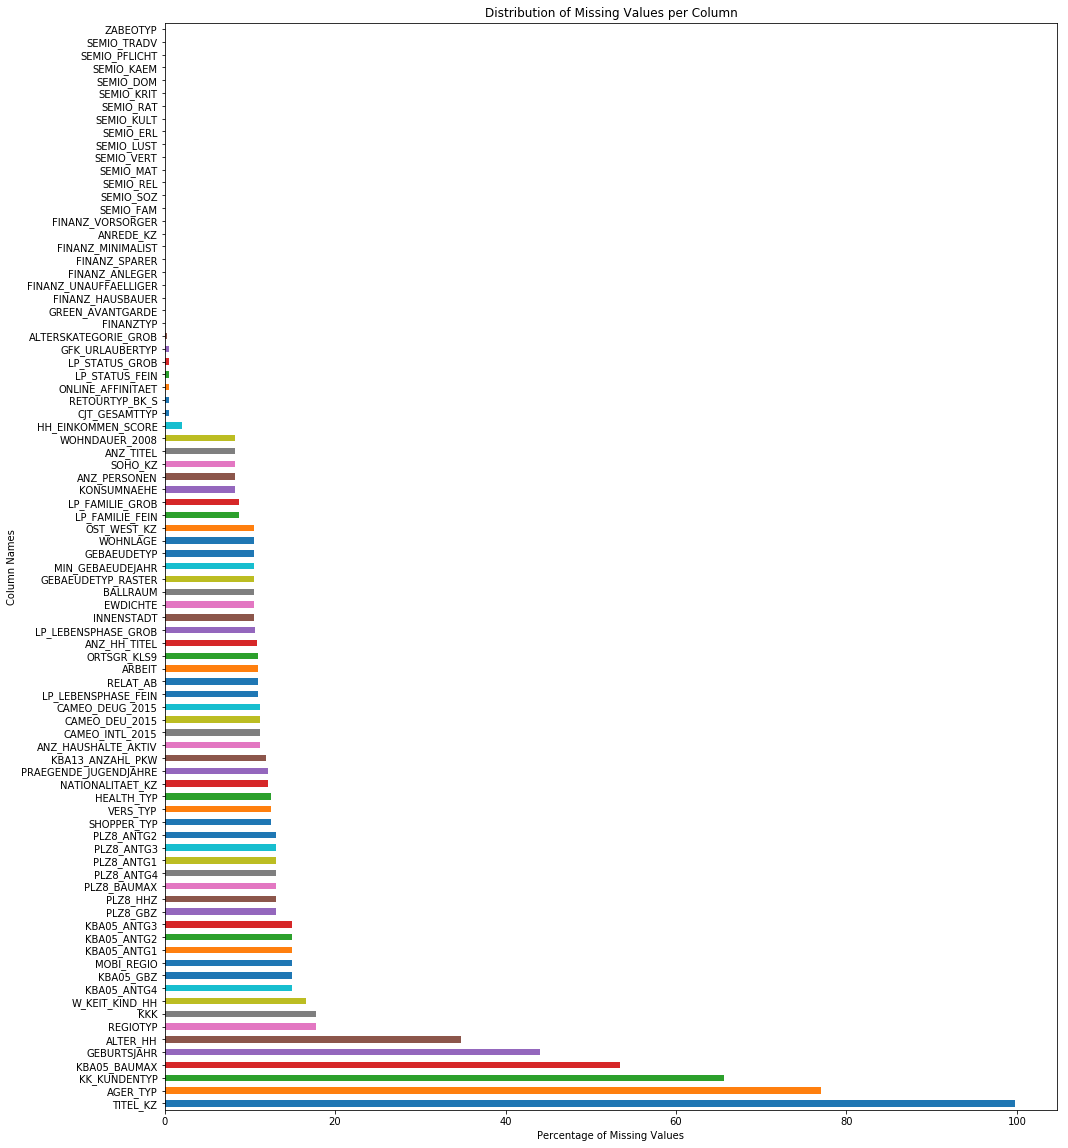

In [23]:
# Visualization of an ordered percentage of missing data in each column of the AZDIAS dataset
sorted_percent_null_column_azdias.plot.barh(figsize=(16,20))
plt.title('Distribution of Missing Values per Column')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Column Names')
plt.show()

### Interpretation:
As we can observe from the above analytical visualization, that there are six columns/features with a lot amount of missing data more than 20% (TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, and ALTER_HH) Therefore, these  columns/features will be excluded from the AZDIAS dataset and will not be involved in any further analysis step of this project.
Thus, I choose 20% as a threshold of columns NaN values(the total number of NaN values per column) 

In [8]:
# Select columns with more than 20% missing data 
columns_threshold = 20
percent_null_column_azdias_20 = sorted_percent_null_column_azdias[sorted_percent_null_column_azdias > columns_threshold]
percent_null_column_azdias_20

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64

In [9]:
# Create a list of outlier columns with more than 20% missing data

outlier_columns = percent_null_column_azdias_20.index.tolist() 

print('List of column names with more than 20% missing values: {}'.format(outlier_columns))
print('Number of columns with more than 20% missing values: {} columns'.format(len(outlier_columns)))

List of column names with more than 20% missing values: ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
Number of columns with more than 20% missing values: 6 columns


In [26]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.) 

# Check the number of columns/features in the AZDIAS dataset before removing the outlier columns
print('There are: {} columns in the AZDIAS dataset'.format(azdias.shape[1]))

There are: 85 columns in the AZDIAS dataset


In [10]:
# Remove the outlier columns/features from the AZDIAS dataset  

azdias.drop(outlier_columns, axis=1, inplace=True)

In [11]:
# Remove the dropped columns from the feature summary file
feat_info = feat_info[~feat_info['attribute'].isin(outlier_columns)]

In [29]:
# Check the number of columns/features in the AZDIAS dataset after removing the outlier columns
print('There are: {} columns in the AZDIAS dataset'.format(azdias.shape[1]))

There are: 79 columns in the AZDIAS dataset


In [30]:
# Check that the removed outlier columns do not exist in the AZDIAS dataset  
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

----------------
Based on the results of the percentage distribution analysis of missing values shown above, I observe that most of the AZDIAS dataset columns have between 0% and 20% NaNs values. However, there are only six columns out of the 85 columns suffer a significant missing data of more than 20%, and the highest percentage of missing data was recorded by 'TITEL_KZ' column with 99.76% NaNs, and the lowest percentage was recorded by 'ALTER_HH' column with 34.81% NaNs 
Thus, I decided to consider these columns/features as outlier ones and remove them from the AZDIAS dataset and from the feature summary file as well. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?

# Explore the total number of missing values in each rows of the AZDIAS dataset
null_row_azdias = azdias.isnull().sum(axis=1)
null_row_azdias

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [32]:
# Investigate patterns in the amount of missing data in each row.
null_row_azdias.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

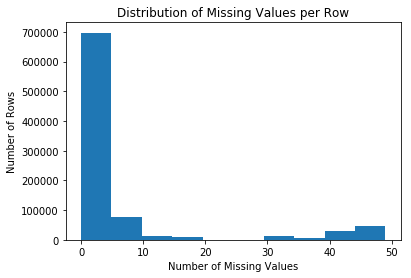

In [33]:
# Visualization of the total number of missing data in each row of the AZDIAS dataset

#null_row_azdias.hist(grid=False) 

plt.hist(null_row_azdias)
plt.title('Distribution of Missing Values per Row')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.show() 

### Interpretation:
From the above histogram plot, we can see a good observation that most of the rows data do not suffer from any missing values (in fact most of them have 0% NaN values). However, we noticed that there are other rows have a lot of missing values above 30 NaN values, Therefore I decided to split the data into two subsets: one for data points that are above 30 for missing values, and a second subset for points below 30. Thus, 30 is the threshold of rows NaN values(the total number of NaN values per row) 

In [13]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Divide the AZDIAS dataset into two subsets
rows_threshold = 30
rows_missing_less_than30 = azdias[null_row_azdias < rows_threshold]
rows_missing_more_than30 = azdias[null_row_azdias >= rows_threshold]

In [35]:
# Check the number of rows in each of the two subsets 
print('There are: {} rows in the first data subset that have less than 30 missing values.'.format(len(rows_missing_less_than30)) 
print('There are: {} rows in the second data subset that have more than 30 missing values.'.format(len(rows_missing_more_than30))

There are: 798061 rows in the first data subset that have less than 30 missing values.
There are: 93160 rows in the second data subset that have more than 30 missing values.


In [13]:
# Select columns with less than 10% of missing values
few_missing_threshold = 10
few_missing_columns = percent_null_column_azdias[percent_null_column_azdias < few_missing_threshold].index.tolist()

In [14]:
# Select the first five subset columns from columns with less than 10% of the missing values 
top_few_missing_columns = few_missing_columns[:5]

In [38]:
# Check the total number of the subset columns 
print(len(top_few_missing_columns))

5


In [39]:
# Display the first five subset columns
print(top_few_missing_columns)

['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER']


In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_distribution_plot(column_name, thirty, subset_rows_less_than30, subset_rows_more_than30):
    fig = plt.figure(10, figsize=(15,4))
    sns.set_palette("BuGn_r")
    
    ax1 = fig.add_subplot(121)
    ax1.set_title('Rows with Missing Values Less Than {}'.format(thirty)) 
    sns.countplot(subset_rows_less_than30.loc[:,column_name], ax=ax1)
    #sns.countplot(subset_rows_less_than30[column_name], ax=ax1) 

    ax2 = fig.add_subplot(122)
    ax2.set_title('Rows with Missing Values More Than {}'.format(thirty))
    sns.countplot(subset_rows_more_than30.loc[:,column_name], ax=ax2)
    #sns.countplot(subset_rows_more_than30[column_name], ax=ax2)  
    
    plt.show()

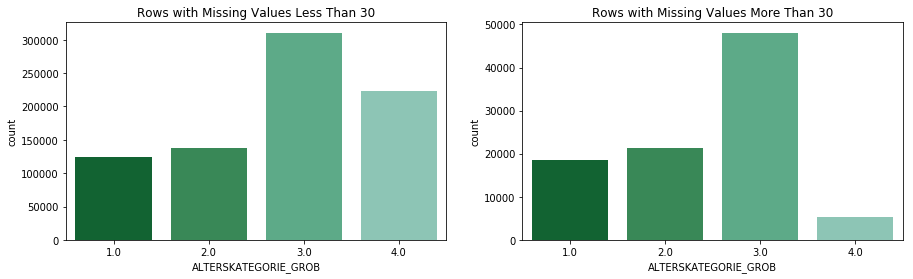

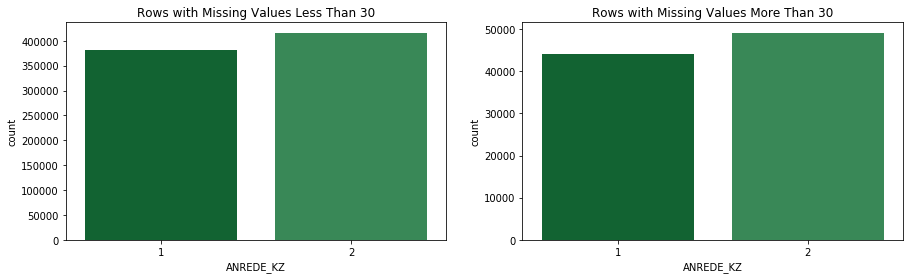

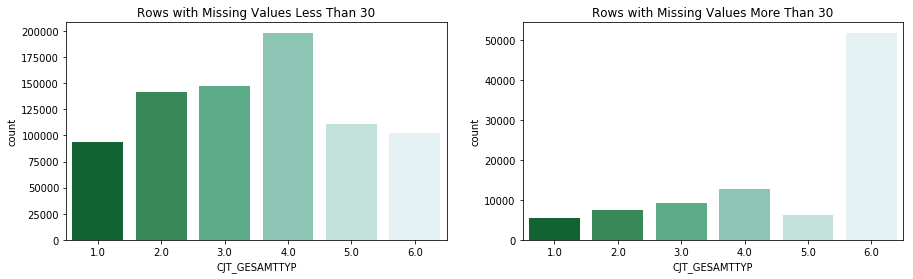

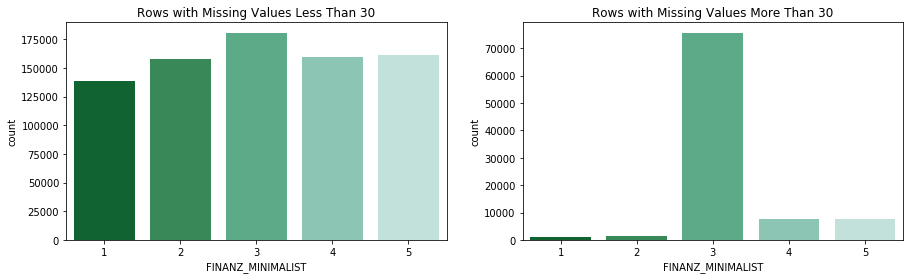

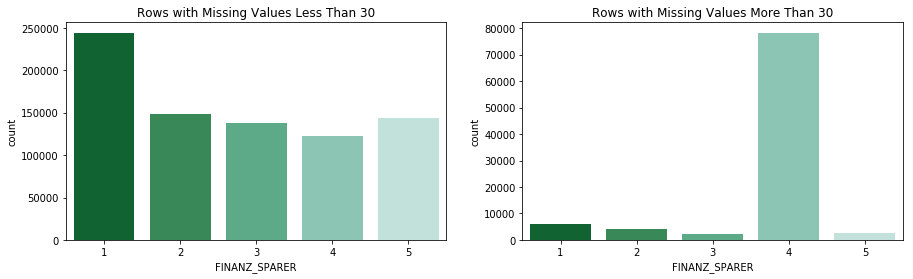

In [18]:
for column in range(len(top_few_missing_columns)):
    compare_distribution_plot(top_few_missing_columns[column], rows_threshold, rows_missing_less_than30, rows_missing_more_than30)

In [43]:
# Check the total number of rows in the AZDIAS dataset before removing the outlier subset rows
print('There are: {} rows in the AZDIAS dataset'.format(azdias.shape[0]))

There are: 891221 rows in the AZDIAS dataset


In [14]:
# Remove the outlier subset rows from the AZDIAS dataset

azdias = azdias[~azdias.index.isin(rows_missing_more_than30.index)]

In [45]:
# Check the total number of rows in the AZDIAS dataset after removing the outlier subset rows
print('There are: {} rows in the AZDIAS dataset'.format(azdias.shape[0]))

There are: 798061 rows in the AZDIAS dataset


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

---------------------------------

After dividing the data into two subsets, one for rows that have missing values below 30 and the other for rows that have missing values above 30, and comparing both subgroups with five columns that have no or few missing values(between 0% and 10% percent of missing values), we observed that the second subgroup (rows with more than 30 missing values) is qualitatively different overall from the other subgroup (rows with less than 30 missing values). Therefore, I decided to consider the subset of rows with more than 30 missing values as outlier rows, and thus go ahead and remove them from the AZDIAS dataset and exclude them from any further analysis step of this project.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [46]:
# Explore the data types of AZDIAS's features in the features summary file
feat_info.head()

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]


In [48]:
# How many features are there of each data type?

# Check the total number of each data type of the AZDIAS's features 
#feat_info.groupby(['type'])['attribute'].count()
feat_info['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [49]:
# Check the dimensions of the AZDIAS dataset before any processing
print(azdias.shape)
print('Number of rows in the AZDIAS dataset:', azdias.shape[0]) 
print('Number of columns in the AZDIAS dataset:', azdias.shape[1])

(798061, 79)
Number of rows in the AZDIAS dataset: 798061
Number of columns in the AZDIAS dataset: 79


In [15]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Select the categorical features/variables in the AZDIAS dataset
categorical_features = feat_info[feat_info.type == 'categorical']
categorical_features

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [51]:
# Total number of the categorical features/variables
print('There are: {} categorical features in the AZDIAS dataset.'.format(len(categorical_features)))

There are: 18 categorical features in the AZDIAS dataset.


In [16]:
# Create a List of categorical features/variables
categorical_features_list = feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].values
categorical_features_list

array(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype=object)

In [53]:
for column in categorical_features_list:
    print(azdias[column].nunique())

2
6
6
12
2
11
5
10
5
3
4
2
2
6
7
2
9
44


In [17]:
# Classify categorical features into binary and multi-level 

binary_categoricals  = []
multi_level_categoricals  = []
 
#for feature in categorical_features.attribute.values:
for feature in categorical_features_list:
    if azdias[feature].nunique() > 2:
        multi_level_categoricals.append(feature)
    else:
        binary_categoricals.append(feature)

In [55]:
# Check binary categoricals
print('There are: {} binary categoricals'.format(len(binary_categoricals)))
print('Column Names: {}'.format(binary_categoricals))

There are: 5 binary categoricals
Column Names: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [57]:
# Check multi-level categoricals
print('There are: {} multi-level categoricals'.format(len(multi_level_categoricals)))
print('Column Names: {}'.format(multi_level_categoricals))

There are: 13 multi-level categoricals
Column Names: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [58]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Check binary categoricals before Re-Encoding them
for column in binary_categoricals:
    print(azdias[column].value_counts())

2    416177
1    381884
Name: ANREDE_KZ, dtype: int64
0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791344
1.0      6717
Name: SOHO_KZ, dtype: int64
2.0    394238
1.0    367102
Name: VERS_TYP, dtype: int64
W    629520
O    168541
Name: OST_WEST_KZ, dtype: int64


In [18]:
# Re-encode Numeric binary categorical varibles   
azdias['ANREDE_KZ'].replace({2:1, 1:0}, inplace=True)
azdias['VERS_TYP'].replace({2.0:1, 1.0:0}, inplace=True)
 
# Re-encode Non-numeric binary categorical varibles
azdias['OST_WEST_KZ'].replace({'W':1,'O':0}, inplace=True)
azdias['OST_WEST_KZ'].astype('int', inplace=True)

1         1
2         1
3         1
4         1
5         1
6         1
7         1
8         1
9         1
10        1
12        1
13        1
15        1
16        1
18        1
19        1
20        1
21        1
22        1
23        1
25        1
26        1
27        1
28        1
29        1
31        1
32        1
33        1
34        1
36        1
         ..
891191    1
891192    1
891193    1
891194    1
891195    1
891196    1
891197    1
891198    1
891199    1
891200    1
891201    1
891202    1
891203    1
891204    1
891205    1
891206    1
891207    1
891208    1
891209    1
891210    1
891211    1
891212    1
891213    1
891214    1
891215    1
891216    1
891217    1
891218    1
891219    1
891220    1
Name: OST_WEST_KZ, Length: 798061, dtype: int64

In [60]:
# Check binary categoricals after Re-Encoding them     
for column in binary_categoricals:
    print(azdias[column].value_counts())

1    416177
0    381884
Name: ANREDE_KZ, dtype: int64
0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791344
1.0      6717
Name: SOHO_KZ, dtype: int64
1.0    394238
0.0    367102
Name: VERS_TYP, dtype: int64
1    629520
0    168541
Name: OST_WEST_KZ, dtype: int64


In [19]:
# Re-encode multi-level categorical varibles  
azdias = pd.get_dummies(azdias, columns = multi_level_categoricals)

In [62]:
# Check the dimensions of the AZDIAS dataset after processing the categorical varibles
print(azdias.shape)
print('Number of rows in the AZDIAS dataset:', azdias.shape[0]) 
print('Number of columns in the AZDIAS dataset:', azdias.shape[1])

(798061, 194)
Number of rows in the AZDIAS dataset: 798061
Number of columns in the AZDIAS dataset: 194


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

-----------------------
In this section, we observed that there are 18 categorical features in the AZDIAS dataset and that these features can be divided into binary categoricals of 5 features and multi-level categoricals of 13 features.
Directly, I re-encoded the binary categorical features (numeric and non-numeric) with values of 0 and 1. And also, I re-encoded the multi-level categorical features using the pd.get_dummies method.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [20]:
# Select the mixed-type features 
mixed_features = feat_info[feat_info["type"] == "mixed"]["attribute"]
mixed_features

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [26]:
# Check the total number of the mixed-type features before dropping 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' columns
len(mixed_features)

6

In [65]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias[['PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_JUGENDJAHRE
1,14.0
2,15.0
3,8.0
4,8.0
5,3.0


In [66]:
# another way
azdias.PRAEGENDE_JUGENDJAHRE.head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [67]:
# Check the total number of the exsiting columns before creating new ones('PRAEGENDE_JUGENDJAHRE_Decade' and 'PRAEGENDE_JUGENDJAHRE_Movement')
azdias.shape[1]

194

In [21]:
# Create decade and movement dictionaries
decade_dic = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 
              9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6} 

movement_dic = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 
                9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

# Create decade new column
azdias['PRAEGENDE_JUGENDJAHRE_Decade'] = azdias['PRAEGENDE_JUGENDJAHRE']
# Mapping decade with new variables
azdias['PRAEGENDE_JUGENDJAHRE_Decade'].replace(decade_dic, inplace=True)

# Create movement new column
azdias['PRAEGENDE_JUGENDJAHRE_Movement'] = azdias['PRAEGENDE_JUGENDJAHRE']
# Mapping movement with new variables
azdias['PRAEGENDE_JUGENDJAHRE_Movement'].replace(movement_dic, inplace=True)

In [69]:
# Check the total number of columns after creating two columns ('PRAEGENDE_JUGENDJAHRE_Decade' and 'PRAEGENDE_JUGENDJAHRE_Movement')
azdias.shape[1]

196

In [70]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias[['CAMEO_INTL_2015']].head()

,CAMEO_INTL_2015
1,51
2,24
3,12
4,43
5,54


In [71]:
# another way
azdias.CAMEO_INTL_2015.head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [72]:
# Check the total number of the exsiting columns before creating new ones('WEALTH' and 'LIFE_STAGE')
azdias.shape[1]

196

In [22]:
# Create wealth and life stage dictionaries   
wealth_dic = {'11':1,'12':1,'13':1,'14':1,'15':1,
              '21':2,'22':2,'23':2,'24':2,'25':2,
              '31':3,'32':3,'33':3,'34':3,'35':3,
              '41':4,'42':4,'43':4,'44':4,'45':4,
              '51':5,'52':5,'53':5,'54':5,'55':5}

life_stage_dic = {'11':1,'12':2,'13':3,'14':4,'15':5,
                  '21':1,'22':2,'23':3,'24':4,'25':5,
                  '31':1,'32':2,'33':4,'34':4,'35':5,
                  '41':1,'42':2,'43':3,'44':4,'45':5,
                  '51':1,'52':2,'53':3,'54':4,'55':5}

# Create wealth new column
azdias['WEALTH'] = azdias['CAMEO_INTL_2015']
# Mapping with new variables 
azdias['WEALTH'].replace(wealth_dic, inplace=True)

# Create life stage new column
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015']
# Mapping with new variables
azdias['LIFE_STAGE'].replace(life_stage_dic, inplace=True)

In [74]:
# Check the total number of columns after creating two columns ('WEALTH' and 'LIFE_STAGE')
#and before removing 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' columns 
azdias.shape[1]

198

In [23]:
# Drop 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' columns

azdias.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)

In [76]:
# Check the total number of features/columns in AZDIAS dataset after removing 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' columns
azdias.shape[1]

196

In [77]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_Decade,PRAEGENDE_JUGENDJAHRE_Movement,WEALTH,LIFE_STAGE
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,6.0,1.0,5.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,6.0,0.0,2.0,4.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,4.0,1.0,1.0,2.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,4.0,1.0,4.0,3.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,2.0,1.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

------------------------------
I applied the same procedure on 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'.

1- created 4 dictionaries for each of the new variables I'm about to create

2- created 4 new variables from the original mixed-type features:  'PRAEGENDE_JUGENDJAHRE_Decade': an interval-type variable, 'PRAEGENDE_JUGENDJAHRE_Movement': a binary variable,  'WEALTH' and 'LIFE_STAGE': as ordinal variables

3- replaced the values of the original mixed type features ("PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015") in the new four generated variables with their corresponding dictionary values 

4- then I drooped the original mixed-type features: 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' from AZDIAS dataset.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [24]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Drop mixed-type features
for feature in mixed_features:
    if feature in azdias.columns:
        azdias.drop(feature, axis=1, inplace=True)   

In [79]:
# Check the final dimensions of the AZDIAS dataset for general demographics
print(azdias.shape)
print('Number of rows in the AZDIAS dataset:', azdias.shape[0]) 
print('Number of columns in the AZDIAS dataset:', azdias.shape[1])

(798061, 192)
Number of rows in the AZDIAS dataset: 798061
Number of columns in the AZDIAS dataset: 192


In [80]:
# Check AZDIAS's features data type 
np.unique(azdias.dtypes.values)

array([dtype('uint8'), dtype('int64'), dtype('float64')], dtype=object)

In [81]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_Decade,PRAEGENDE_JUGENDJAHRE_Movement,WEALTH,LIFE_STAGE
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,6.0,1.0,5.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,6.0,0.0,2.0,4.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,4.0,1.0,1.0,2.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,4.0,1.0,4.0,3.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,2.0,1.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [25]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # Load in the feature summary file.
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep =';')
    
    # Convert missing values into NANs
    for df_record in range(len(feat_info)):
        df_missing_or_unknown = feat_info.iloc[df_record]['missing_or_unknown']
        df_missing_or_unknown = df_missing_or_unknown.strip('[')
        df_missing_or_unknown = df_missing_or_unknown.strip(']')
        df_missing_or_unknown = df_missing_or_unknown.split(sep=',')
        df_missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in df_missing_or_unknown]
        if df_missing_or_unknown != ['']:
            df = df.replace({feat_info.iloc[df_record]['attribute']: df_missing_or_unknown}, np.nan)
	    
        
        
        
    # remove selected columns and rows, ...
    
    # Drop columns that have more than 20% missing data 
    df_outlier_columns = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    df.drop(columns=df_outlier_columns, axis=1, inplace=True)


    # Drop rows that have more than 30 missing data 
    df_null_row = df.isnull().sum(axis=1)
    df_rows_threshold = 30
    df_rows_missing_less_than30 = df[df_null_row < df_rows_threshold]
    df_rows_missing_more_than30 = df[df_null_row >= df_rows_threshold]
    df = df[~df.index.isin(df_rows_missing_more_than30.index)]
    
    
    # select, re-encode, and engineer column values.
    
    # Select categorical features
    feat_info=feat_info[feat_info.attribute.isin(df.columns)]
    df_categorical_features = feat_info[feat_info.type=="categorical"]       
    df_binary_categoricals  = []
    df_multi_level_categoricals  = []
    for feature in df_categorical_features.attribute: 
        if df[feature].nunique() > 2:       
            df_multi_level_categoricals.append(feature)
        else:
            df_binary_categoricals.append(feature)
    
    #Re-encode
    df["ANREDE_KZ"].replace({2:1,1:0}, inplace=True)
    df["SOHO_KZ"].replace({0.0:0,1.0:1}, inplace=True)
    df["OST_WEST_KZ"].replace({'W':1,'O':0}, inplace=True)
    df = pd.get_dummies(df, columns=df_multi_level_categoricals)

    
    # Create dictionaries
    df_wealth_dic = {'11':1,'12':1,'13':1,'14':1,'15':1,
                     '21':2,'22':2,'23':2,'24':2,'25':2,
                     '31':3,'32':3,'33':3,'34':3,'35':3,
                     '41':4,'42':4,'43':4,'44':4,'45':4,
                     '51':5,'52':5,'53':5,'54':5,'55':5}

    df_life_stage_dic = {'11':1,'12':2,'13':3,'14':4,'15':5,
                         '21':1,'22':2,'23':3,'24':4,'25':5,
                         '31':1,'32':2,'33':4,'34':4,'35':5,
                         '41':1,'42':2,'43':3,'44':4,'45':5,
                         '51':1,'52':2,'53':3,'54':4,'55':5}

    # Create new columns 
    df['WEALTH'] = df['CAMEO_INTL_2015']
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015']

    # Mapping values
    df['WEALTH'].replace(df_wealth_dic, inplace=True)
    df['LIFE_STAGE'].replace(df_life_stage_dic, inplace=True)

    # Drop column
    df.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)
    
    # Drop mixed-type features 
    df_mixed_features = feat_info[feat_info["type"] == "mixed"]["attribute"] 
    for df_feature in df_mixed_features:
    	if df_feature in df.columns:
    		df.drop(df_feature, axis=1, inplace=True)

    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [26]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Drop all NAN values 
cleaned_azdias = azdias.dropna(axis = 0, how ='any')

In [32]:
# Check the total number of NANs after dropping all rows with NaN values 
cleaned_azdias.isnull().sum().sum()

0

In [33]:
print("Old data frame length:", len(azdias))
print("New data frame length:", len(cleaned_azdias)) 
print("Number of rows with at least 1 NAN value: ", (len(azdias)-len(cleaned_azdias)))

Old data frame length: 798061
New data frame length: 623211
Number of rows with at least 1 NAN value:  174850


In [34]:
cleaned_azdias.shape

(623211, 192)

In [27]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_azdias = scaler.fit_transform(cleaned_azdias)
scaled_azdias = pd.DataFrame(scaled_azdias, columns = cleaned_azdias.columns)

In [31]:
scaled_azdias.shape

(623211, 192)

In [32]:
scaled_azdias

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_Decade,PRAEGENDE_JUGENDJAHRE_Movement,WEALTH,LIFE_STAGE
0,-1.746287,0.977825,-1.512226,1.581061,-1.045045,1.539061,1.047076,1.340485,-0.553672,1.044646,...,-0.157429,-0.165818,-0.196773,-0.185007,-0.196619,-0.075861,1.164455,0.553672,1.147884,-1.254955
1,0.202108,0.977825,-1.512226,0.900446,-1.765054,-0.531624,0.318375,1.340485,1.806125,1.044646,...,-0.157429,-0.165818,-0.196773,-0.185007,-0.196619,-0.075861,1.164455,-1.806125,-0.909992,0.739445
2,0.202108,-1.022678,0.692400,0.219832,0.394972,-1.221852,0.318375,-0.856544,-0.553672,1.044646,...,-0.157429,-0.165818,-0.196773,-0.185007,-0.196619,-0.075861,-0.213395,0.553672,0.461926,0.074645
3,-1.746287,0.977825,-0.042475,-1.141397,1.114980,-0.531624,-0.410325,1.340485,-0.553672,1.044646,...,-0.157429,-0.165818,-0.196773,-0.185007,-0.196619,-0.075861,-1.591245,0.553672,1.147884,0.739445
4,-0.772089,0.977825,-1.512226,1.581061,-1.765054,1.539061,1.047076,-0.124201,-0.553672,-0.273495,...,-0.157429,-0.165818,-0.196773,-0.185007,-0.196619,-0.075861,0.475530,0.553672,-0.909992,-0.590155
5,-1.746287,-1.022678,-0.042475,0.219832,0.394972,-1.221852,0.318375,-0.856544,-0.553672,-1.591635,...,-0.157429,-0.165818,-0.196773,-0.185007,-0.196619,-0.075861,-0.213395,0.553672,-1.595951,0.739445
6,0.202108,-1.022678,0.692400,0.900446,-1.045045,0.848833,-0.410325,-0.856544,1.806125,1.044646,...,-0.157429,-0.165818,-0.196773,-0.185007,-0.196619,-0.075861,0.475530,-1.806125,-1.595951,0.074645
7,0.202108,0.977825,-0.777350,0.900446,-1.045045,0.158605,1.775776,0.608142,1.806125,-0.273495,...,-0.157429,-0.165818,-0.196773,-0.185007,-0.196619,-0.075861,1.164455,-1.806125,-1.595951,1.404245
8,0.202108,0.977825,-0.777350,-0.460783,1.114980,0.158605,-1.139026,1.340485,-0.553672,-0.273495,...,-0.157429,-0.165818,-0.196773,-0.185007,5.085978,-0.075861,-1.591245,0.553672,1.147884,-1.254955
9,0.202108,-1.022678,1.427276,-0.460783,-0.325037,-1.221852,0.318375,-1.588887,1.806125,1.044646,...,-0.157429,-0.165818,-0.196773,-0.185007,-0.196619,-0.075861,-0.213395,-1.806125,-0.224033,0.739445


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

--------------------------
After exploring the total number of NaNs or missing values in the AZDIAS dataset, it turned out that there were still some rows: 174850 rows with at least one null value, so I decided to go ahead and drop those records, thus removing them constitutes approximately 20% of the total data available in the AZDIAS dataset which is not a huge data loss. Moreover, I used the StandardScaler instance to scale features with a mean of 0 and a standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [27]:
# Apply PCA to the data.
pca = PCA()
pca_azdias = pca.fit_transform(scaled_azdias)

In [32]:
# Check the dimensions of the AZDIAS dataset before applying PCA (dimensionality reduction technique) 
pca_azdias.shape

(623211, 192)

In [ ]:
pca_azdias

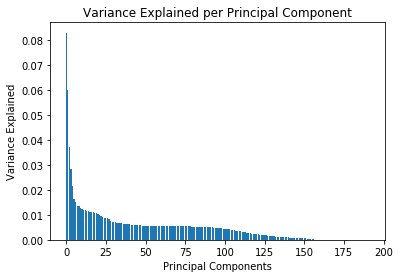

In [35]:
# Investigate the variance accounted for by each principal component.
num_components = len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_

plt.bar(ind, vals)
plt.title("Variance Explained per Principal Component")
plt.xlabel("Principal Components")
plt.ylabel("Variance Explained")
plt.show()

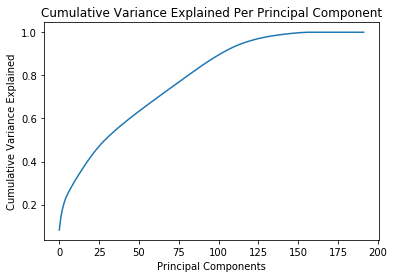

In [36]:
cumvals = np.cumsum(vals) 

plt.plot(ind, cumvals)
plt.title("Cumulative Variance Explained Per Principal Component")
plt.xlabel("Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.show()

In [28]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 80)
pca_azdias = pca.fit_transform(scaled_azdias)

In [34]:
# Check the dimensions of the AZDIAS dataset after applying PCA (dimensionality reduction technique) 
pca_azdias.shape

(623211, 80)

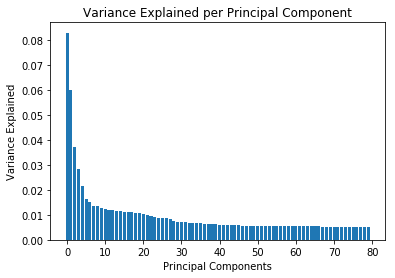

In [42]:
num_components = len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_

plt.bar(ind, vals)
plt.title("Variance Explained per Principal Component")
plt.xlabel("Principal Components")
plt.ylabel("Variance Explained")
plt.show()

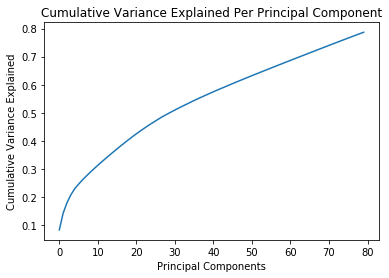

In [43]:
cumvals = np.cumsum(vals) 

plt.plot(ind, cumvals)
plt.title("Cumulative Variance Explained Per Principal Component")
plt.xlabel("Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.show()

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

---------------------------
Based on the above graph, I noticed that by applying 80 principal components, I would have over 80% of the cumulative variance explained. Hence, I decided to keep the top 80 components. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [29]:
# Function to calculate weights for principal component to corresponding feature names

def weights_pca_map(df, pca, weight):
    weighted_pca_df = pd.DataFrame(list(pca.components_), columns = list(df.columns)).iloc[weight]
    weighted_pca_df.sort_values(ascending = False, inplace = True)
    weighted_pca_df = pd.concat([weighted_pca_df.head(), weighted_pca_df.tail()])
    
    return weighted_pca_df

In [28]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

weights_pca_map(scaled_azdias, pca, 0)

LP_STATUS_GROB_1.0    0.192300
HH_EINKOMMEN_SCORE    0.180700
WEALTH                0.179920
PLZ8_ANTG3            0.175734
PLZ8_ANTG4            0.170176
PLZ8_ANTG1           -0.178204
KBA05_GBZ            -0.178354
KBA05_ANTG1          -0.190063
FINANZ_MINIMALIST    -0.194756
MOBI_REGIO           -0.201564
Name: 0, dtype: float64

In [29]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_pca_map(scaled_azdias, pca, 1)

ALTERSKATEGORIE_GROB            0.226899
FINANZ_VORSORGER                0.205737
ZABEOTYP_3                      0.199108
SEMIO_ERL                       0.182299
RETOURTYP_BK_S                  0.156608
SEMIO_PFLICHT                  -0.206684
FINANZ_UNAUFFAELLIGER          -0.207267
FINANZ_SPARER                  -0.213362
SEMIO_REL                      -0.215495
PRAEGENDE_JUGENDJAHRE_Decade   -0.229097
Name: 1, dtype: float64

In [30]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_pca_map(scaled_azdias, pca, 2)

SEMIO_VERT     0.319916
SEMIO_FAM      0.257907
SEMIO_SOZ      0.255291
SEMIO_KULT     0.243476
FINANZTYP_5    0.139470
SEMIO_ERL     -0.199474
SEMIO_KRIT    -0.259573
SEMIO_DOM     -0.279708
SEMIO_KAEM    -0.312349
ANREDE_KZ     -0.341354
Name: 2, dtype: float64

In [30]:
# Function to plot weights for principal component to corresponding feature names
def weights_pca_plot(df, pca, weight):

    weighted_pca_df = weights_pca_map(df, pca, weight)

    weighted_pca_df.plot(kind = 'bar', title = 'Component '+str(weight), color='lightseagreen')
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()

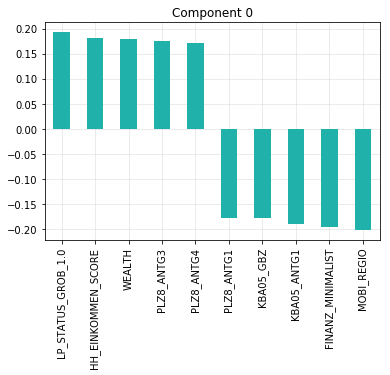

None


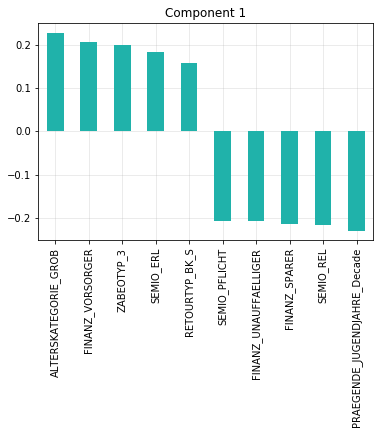

None


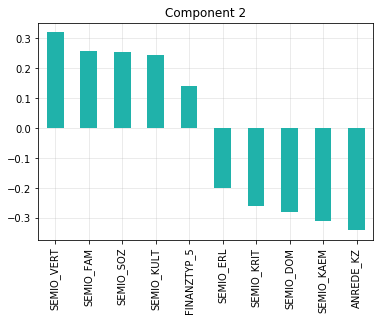

None


In [32]:
for weight in range(3):
    print(weights_pca_plot(scaled_azdias, pca, weight))

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

--------------------



We can interpret some features from the first principal component as follow:

##### positive feature weights

-  LP_STATUS_GROB_1.0: Social status, low-income earners
    
- HH_EINKOMMEN_SCORE: Estimated household net income (higher is lower income)
    
- WEALTH: Household wealth (higher is lower income)
    

##### negative feature weights are

- MOBI_REGIO: Movement patterns (higher is lower)
- FINANZ_MINIMALIST: Financial typology, low financial interest (higher is lower)
- KBA05_ANTG1: Number of 1-2 family houses in the microcell (higher is higher)

We can see that the first component has relationship with social status, financial status, movement, family and household size.  

--------------------------------------

We can interpret some features from the second principal component as follow:

##### positive feature weights

- ALTERSKATEGORIE_GROB: Estimated age (higher is older)
- FINANZ_VORSORGER: Financial typology, be prepared (higher is lower)
- ZABEOTYP_3: Energy consumption typology, fair supplied

##### negative feature weights 

- PRAEGENDE_JUGENDJAHRE_Decade: Generation
- SEMIO_REL: Religious
- FINANZ_SPARER: Financial typology, money-saver (higher is lower)

We can see that the second component has a relationship with age, energy consumption, decade, and financial typology.

--------------------------------------------


We can interpret some features from the third principal component as follow:

##### positive feature weights 

- SEMIO_VERT: Personality typology, dreamful (higher is lower)
- SEMIO_FAM: Personality typology, family-minded (higher is lower)
- SEMIO_SOZ: Personality typology, socially-minded (higher is lower)

##### negative feature weights

- ANREDE_KZ: Gender (male, femal)
- SEMIO_KAEM: Personality typology, combative-attitude (higher is lower)
- SEMIO_DOM: Personality typology, dominant-minded (higher is lower)

We can see that the third component has a relationship with personality and gender.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...

scores = []
num_clusters = list(range(10, 25))

for k in num_clusters:

    # run k-means clustering on the data and...
    kmeans = MiniBatchKMeans(k)
    kmeans_model = kmeans.fit(pca_azdias)
    # compute the average within-cluster distances.
    score = np.abs(kmeans_model.score(pca_azdias))
    scores.append(score)

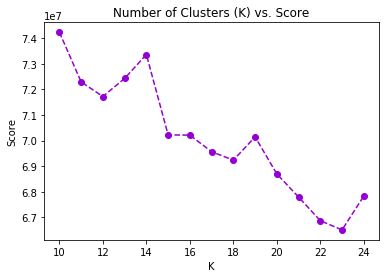

In [33]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(num_clusters, scores, marker='o', linestyle='--', color='darkviolet')
plt.title('Number of Clusters (K) vs. Score')
plt.xlabel('K')
plt.ylabel('Score')
plt.show()

In [30]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(20)
kmeans_model = kmeans.fit(pca_azdias)
azdias_pred = kmeans_model.predict(pca_azdias)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

---------------------------
When I used KMeans, it took over an hour to run, so I had to use MiniBatchKMeans to make the run much faster.
However, I didn't get a clear elbow point from the above graph, but I think choosing a k value of 20 is a good choice
Thus, I decided to go ahead and refit the k-mean model with 20 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [31]:
# Load in the customer demographics data.

customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [36]:
customers.shape

(191652, 85)

In [37]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [32]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

cleaned_customers = clean_data(customers)

In [52]:
cleaned_customers.shape

(141725, 189)

In [53]:
cleaned_customers.isnull().sum().sum()

101750

In [33]:
# Drop all NAN values 
cleaned_customers = cleaned_customers.dropna(axis = 0, how ='any')

In [55]:
cleaned_customers.isnull().sum().sum()

0

In [56]:
cleaned_customers.shape

(115957, 189)

In [66]:
cleaned_customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,WEALTH,LIFE_STAGE
0,4.0,0,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,0,0,1.0,3.0
2,4.0,1,5,1,5,1,4,4,1,2.0,...,0,0,0,0,0,0,0,0,3.0,4.0
4,3.0,0,3,1,4,4,5,2,0,3.0,...,0,0,0,0,0,0,0,0,4.0,1.0
5,3.0,0,5,1,5,1,2,3,1,3.0,...,0,0,0,0,0,0,0,0,3.0,4.0
6,4.0,0,5,1,5,1,1,2,1,2.0,...,0,0,0,0,0,0,0,0,2.0,3.0


In [34]:
# Apply feature scaling to the customers data
scaler = StandardScaler()
scaled_customers = scaler.fit_transform(cleaned_customers)
scaled_customers = pd.DataFrame(cleaned_customers, columns = cleaned_customers.columns)

In [35]:
# Apply PCA to the customers data
pca = PCA(n_components = 80)
pca_customers = pca.fit_transform(scaled_customers)

In [71]:
pca_customers.shape

(115957, 80)

In [36]:
# Fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the customers data
kmeans = KMeans(20)
kmeans_model = kmeans.fit(pca_customers)
customers_pred = kmeans_model.predict(pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Clusters')

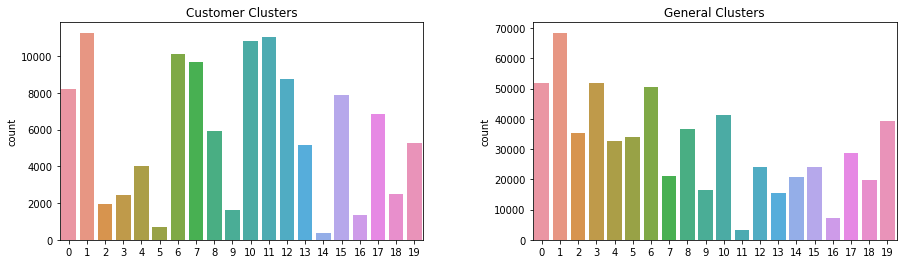

In [75]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (15,4))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customers_pred, ax=axs[0])
axs[0].set_title('Customer Clusters')

sns.countplot(azdias_pred, ax=axs[1])
axs[1].set_title('General Clusters')

In [37]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_1 = scaler.inverse_transform(pca.inverse_transform(kmeans_model.cluster_centers_[1]))
overrepresented_cluster = pd.Series(data = centroid_1, index = cleaned_customers.columns)

In [38]:
overrepresented_cluster

ALTERSKATEGORIE_GROB      5.928073
ANREDE_KZ                 0.469903
FINANZ_MINIMALIST         8.696317
FINANZ_SPARER             2.486257
FINANZ_VORSORGER          8.392110
FINANZ_ANLEGER            3.027579
FINANZ_UNAUFFAELLIGER     3.471902
FINANZ_HAUSBAUER          6.170270
GREEN_AVANTGARDE          0.808495
HEALTH_TYP                3.452735
RETOURTYP_BK_S            8.552528
SEMIO_SOZ                11.512285
SEMIO_FAM                10.258743
SEMIO_REL                 7.592144
SEMIO_MAT                10.206959
SEMIO_VERT               14.251256
SEMIO_LUST               14.603866
SEMIO_ERL                13.451184
SEMIO_KULT               10.855605
SEMIO_RAT                 6.584037
SEMIO_KRIT               10.697877
SEMIO_DOM                10.350641
SEMIO_KAEM                9.791310
SEMIO_PFLICHT             6.964115
SEMIO_TRADV               6.852064
SOHO_KZ                   0.010772
VERS_TYP                  2.253094
ANZ_PERSONEN              5.621518
ANZ_TITEL           

In [39]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_14 = scaler.inverse_transform(pca.inverse_transform(kmeans_model.cluster_centers_[14]))
underrepresented_cluster = pd.Series(data = centroid_14, index = cleaned_customers.columns)

In [40]:
underrepresented_cluster

ALTERSKATEGORIE_GROB      5.876862
ANREDE_KZ                 0.486178
FINANZ_MINIMALIST         8.230892
FINANZ_SPARER             2.641802
FINANZ_VORSORGER          8.174517
FINANZ_ANLEGER            3.238554
FINANZ_UNAUFFAELLIGER     3.387083
FINANZ_HAUSBAUER          6.861741
GREEN_AVANTGARDE          0.715279
HEALTH_TYP                3.459794
RETOURTYP_BK_S            8.531552
SEMIO_SOZ                11.538073
SEMIO_FAM                10.428266
SEMIO_REL                 7.632260
SEMIO_MAT                10.275061
SEMIO_VERT               13.991898
SEMIO_LUST               14.337726
SEMIO_ERL                13.622239
SEMIO_KULT               10.798178
SEMIO_RAT                 6.755795
SEMIO_KRIT               10.903925
SEMIO_DOM                10.468233
SEMIO_KAEM               10.171809
SEMIO_PFLICHT             7.095091
SEMIO_TRADV               6.863608
SOHO_KZ                   0.010606
VERS_TYP                  2.252779
ANZ_PERSONEN              5.453775
ANZ_TITEL           

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

------------------------------

As we can see from the chart above, cluster points 1, 12, and 11 are highly potential customer segments. On the other hand, we can see that cluster points 14, 5, and 9 are less likely to be potential customers of the mail-order company.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.